In [2]:
import pickle
import lzma

with lzma.open('movie_data_movielens.xz', 'rb') as f:
    train_movie_ratings_list, test_movie_ratings_list = pickle.load(f)

with lzma.open('user_data_movielens.xz', 'rb') as f:
    train_user_ratings_list, test_user_ratings_list = pickle.load(f)

In [3]:
with lzma.open('params_with_f_k=2_2024-05-06 10:13:31.086363.xz', 'rb') as f:
    params = pickle.load(f)

locals().update(params)

In [4]:
with lzma.open('movies_map.xz', 'rb') as f:
    title_to_id_moviesmap, id_to_title_moviesmap = pickle.load(f)

In [5]:
with lzma.open('general_movielens.xz', 'rb') as f:
    userid_to_index, index_to_userid, movieid_to_index, index_to_movieid = pickle.load(f)

In [6]:
with lzma.open('feature_vectors.xz', 'rb') as f:
    movieid_to_feature_vector = pickle.load(f)

In [7]:
import numpy as np
feature_vectors = np.zeros((len(movieid_to_feature_vector), 19), dtype=int)

In [8]:
for val in movieid_to_feature_vector.keys():
    try:
        movie_index = movieid_to_index[val]
        feature_vectors[movie_index] = movieid_to_feature_vector[val]
    except KeyError:
        continue

In [7]:
feature_vectors.shape

(62423, 19)

In [8]:
import numpy as np

def arraylize(input_list):
    return [np.array(val) for val in input_list]

train_movie_ratings_list = arraylize(train_movie_ratings_list)
test_movie_ratings_list = arraylize(test_movie_ratings_list)
train_user_ratings_list = arraylize(train_user_ratings_list)
test_user_ratings_list = arraylize(test_user_ratings_list)

In [11]:
genre_list = ['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir']

In [17]:
M = len(train_user_ratings_list)
N = len(train_movie_ratings_list)

user_biases = np.zeros((M))
item_biases = np.zeros((N))
num_features = (feature_vectors.shape)[-1]

# Hyperparameters
n_epochs = 100
lmb = 1
gamma = 0.1
tau = 1
k = 2
jitter = 1e-8

U = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(M, k))
V = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(N, k))
F = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(num_features, k))

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

  0%|          | 0/100 [00:00<?, ?it/s]

train loss 7533859.51 test loss 2104413.42 train rmse 0.8594 test rmse 0.8847
train loss 7110648.89 test loss 2006166.25 train rmse 0.8347 test rmse 0.8635
train loss 6871778.3 test loss 1943199.38 train rmse 0.8203 test rmse 0.8487
train loss 6657014.4 test loss 1887511.16 train rmse 0.8071 test rmse 0.8354
train loss 6541454.86 test loss 1858175.03 train rmse 0.7999 test rmse 0.8283
train loss 6486821.24 test loss 1844357.95 train rmse 0.7964 test rmse 0.825
train loss 6457166.68 test loss 1836938.82 train rmse 0.7946 test rmse 0.8231
train loss 6437293.67 test loss 1831973.96 train rmse 0.7933 test rmse 0.8219
train loss 6421683.08 test loss 1828071.36 train rmse 0.7923 test rmse 0.8209
train loss 6408916.24 test loss 1824925.51 train rmse 0.7915 test rmse 0.8201
train loss 6398855.37 test loss 1822546.14 train rmse 0.7908 test rmse 0.8194
train loss 6391305.43 test loss 1820920.93 train rmse 0.7903 test rmse 0.8189
train loss 6385844.39 test loss 1819922.73 train rmse 0.79 test rms

KeyboardInterrupt: 

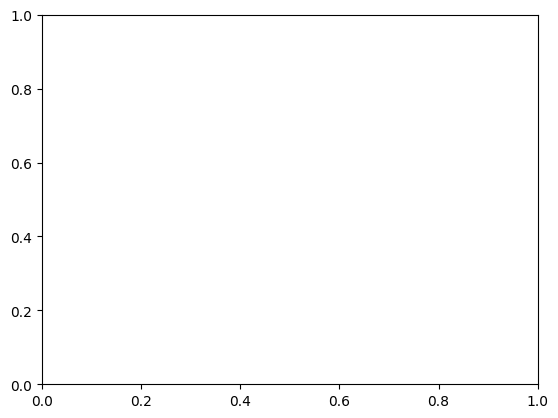

In [18]:
from tqdm.notebook import tqdm
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

artists = []

for p in tqdm(range(n_epochs)):    
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_ratings_list) > 0:
            ratings = train_user_ratings_list[m][:, 1]
            indices = train_user_ratings_list[m][:, 0].astype(int)
            
            # Calculate user bias
            user_bias = lmb * np.sum(ratings - np.einsum('i,ji->j', U[m], V[indices]) - item_biases[indices]) / (lmb * len(indices) + gamma)
            user_biases[m] = user_bias
            
            # Calculate left and right matrices for user factor update
            left = np.sum(np.einsum('ij,il->ijl', V[indices], V[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', V[indices], ratings - user_bias - item_biases[indices]), axis=0)
            
            # Update user factor
            U[m] = np.linalg.solve(lmb * left + tau * np.eye(k), lmb * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_ratings_list[n]) > 0:
            ratings = train_movie_ratings_list[n][:, 1]
            indices = train_movie_ratings_list[n][:, 0].astype(int)
            
            # Calculate item bias
            item_bias = lmb * np.sum(ratings - np.einsum('ij,j->i', U[indices], V[n]) - user_biases[indices]) / (lmb * len(indices) + gamma)
            item_biases[n] = item_bias
            
            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', U[indices], U[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', U[indices], ratings - user_biases[indices] - item_bias), axis=0)

            total_right = lmb * right + tau * 1/np.sqrt(np.sum(feature_vectors[n])+jitter) * np.einsum('i, ij -> j', feature_vectors[n], F)
            # Update item factor
            V[n] = np.linalg.solve(lmb * left + tau * np.eye(k), total_right)

    for i in range(num_features):
        indices = np.where(feature_vectors[:, i] == 1) # get movies with ith feature
        feature_sums = np.sum(feature_vectors[indices], axis=1) # get number of features for movies containing ith feature
        features_except_i = np.delete(feature_vectors, i, axis=1)[indices] # get other features except ith feature for movies with ith feature
        F_except_i = np.delete(F, i, axis=0) # get feature embeddings for other features except ith feature
        # calculate feature update
        total_right = np.sum(V[indices] * 1/np.sqrt(feature_sums)[..., None] - 1/feature_sums[..., None] * np.einsum('ij, jk -> ik', features_except_i, F_except_i), axis=0)         
        F[i] = total_right/(np.sum(1/np.sqrt(feature_sums)) - 1)

    # Calculate loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0
    
    for m in range(M):
        if len(train_user_ratings_list[m]) > 0:
            train_ratings = train_user_ratings_list[m][:, 1]
            train_indices = train_user_ratings_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', U[m], V[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)
            
        if len(test_user_ratings_list[m]) > 0:
            test_ratings = test_user_ratings_list[m][:, 1]
            test_indices = test_user_ratings_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', U[m], V[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)
        
    train_loss = -0.5 * lmb * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', V, V) + np.einsum('ij,ij->', U, U))
    train_rmse = np.sqrt(1 / train_size * train_error_squared)
    
    train_losses.append(-1*train_loss)
    train_rmses.append(train_rmse)

    test_loss = -0.5 * lmb * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', V, V) + np.einsum('ij, ij->', U, U))
    test_rmse = np.sqrt(1/test_size * test_error_squared)
    
    test_losses.append(-1*test_loss)
    test_rmses.append(test_rmse)
      
    print(f'train loss {round(-1*train_loss, 2)} test loss {round(-1*test_loss, 2)} train rmse {round(train_rmse, 4)} test rmse {round(test_rmse, 4)}')

# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=200, blit=True)
# ani.save('main.gif')
# plt.show()

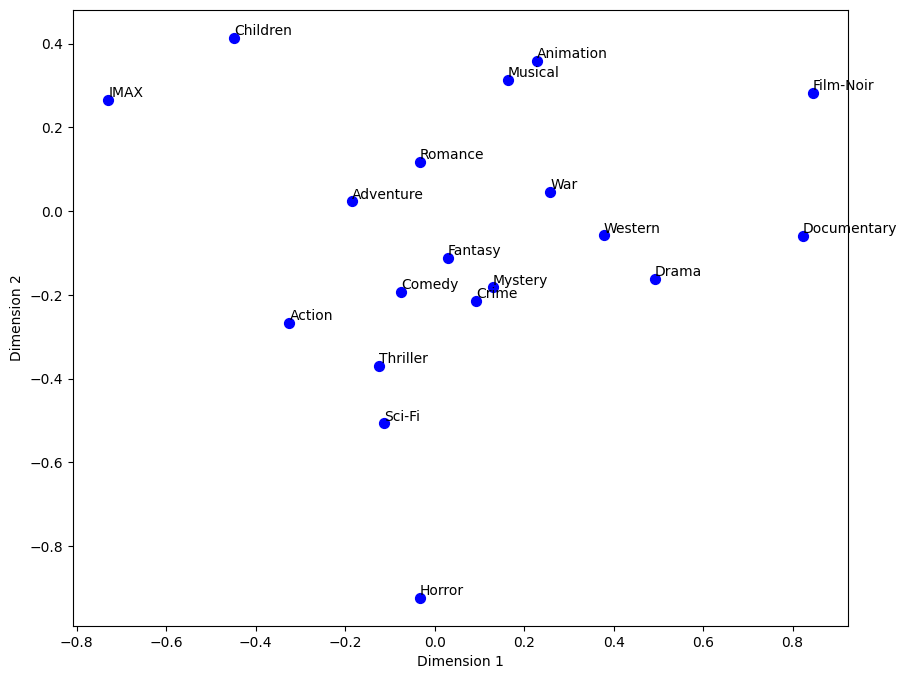

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(F[:,0], F[:,1], c='blue', s=50)
for q, txt in enumerate(genre_list):
    ax.annotate(txt, (F[q,0], F[q,1]), horizontalalignment='left', verticalalignment='bottom')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.savefig('feature_embedding_plots.pdf', bbox_inches='tight')

In [30]:
ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=200, blit=True)
ani.save('main.gif')
plt.show()

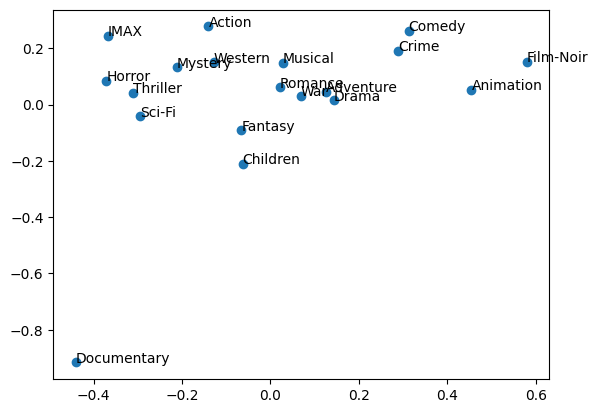

In [31]:
fig, ax = plt.subplots()


ax.scatter(F[:,0], F[:,1])
for i, txt in enumerate(genre_list):
    ax.annotate(txt, (F[i,0], F[i,1]))
container = ax

In [15]:
params = {
    'user_biases':user_biases,
    'item_biases':item_biases,
    'n_epochs':n_epochs, 
    'lmb':lmb, 
    'gamma':gamma, 
    'tau':tau, 
    'k': k, 
    'U':U, 
    'V': V, 
    'train_rmses':train_rmses, 
    'train_losses':train_losses,
    'test_rmses': test_rmses,
    'test_losses': test_losses,
    'F': F
}

In [16]:
import pickle
import lzma
import datetime;
 
# ct stores current time
ct = datetime.datetime.now()

with lzma.open(f'params_with_f_k={k}_{ct}.xz', 'wb') as f:
    pickle.dump(params, f, protocol=4)